### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

In [61]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA Not available.')
else:
    print('CUDA Available.')
    
torch.device("cuda")
torch.cuda.current_device()

CUDA Available.


0

### Load the Data

In [9]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [138]:
batch_size = 28
num_workers = 0
valid_size = 0.20 # Percent of training to use as validation

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),
                                                   (0.5,0.5,0.5))])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

num_train = len(train_data)
print("num_train %s" % num_train)
indices = list(range(num_train))
print(indices[0:20])
np.random.shuffle(indices)
print(indices[0:20])
split = int(np.floor(valid_size * num_train))
print(split)
train_idx, valid_idx = indices[split:], indices[split:]
print(train_idx[0:20])
print(valid_idx[0:20])
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Prepare Data Loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

#Specify the image classes
classes = ['airplane','automobile','bird','cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
num_train 50000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[38866, 18030, 12815, 23212, 40890, 29363, 43700, 6445, 7212, 40525, 36861, 36982, 34131, 5479, 14613, 41197, 19709, 36231, 4294, 41760]
10000
[15348, 23570, 29829, 10760, 47172, 4634, 40861, 5659, 8984, 33993, 15399, 39978, 24213, 3511, 45966, 11466, 23667, 48215, 47552, 23824]
[15348, 23570, 29829, 10760, 47172, 4634, 40861, 5659, 8984, 33993, 15399, 39978, 24213, 3511, 45966, 11466, 23667, 48215, 47552, 23824]


### Visualize Batch of Training Data

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 #Unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #Convert from Tensor

<class 'torch.Tensor'>


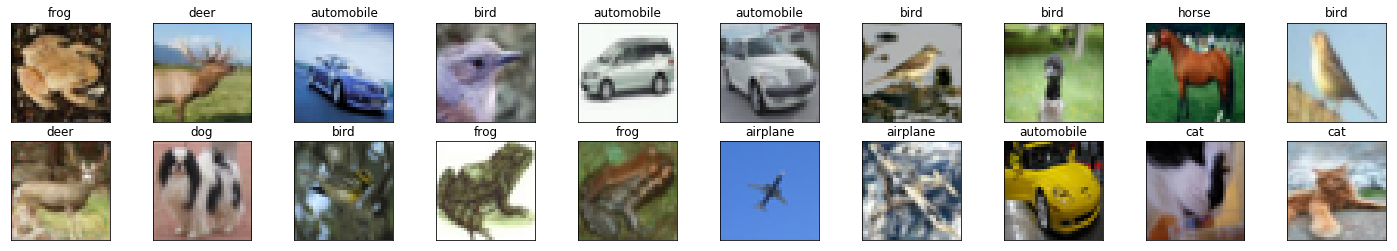

In [140]:
images,labels = next(iter(train_loader))
print(type(labels))
images = images.numpy() #Convert images to numpy for display
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View each channel of images separately

shape of images: (3, 32, 32)
type: (3, 32, 32) 	 shape: (3, 32, 32)
32 32
32 32
32 32


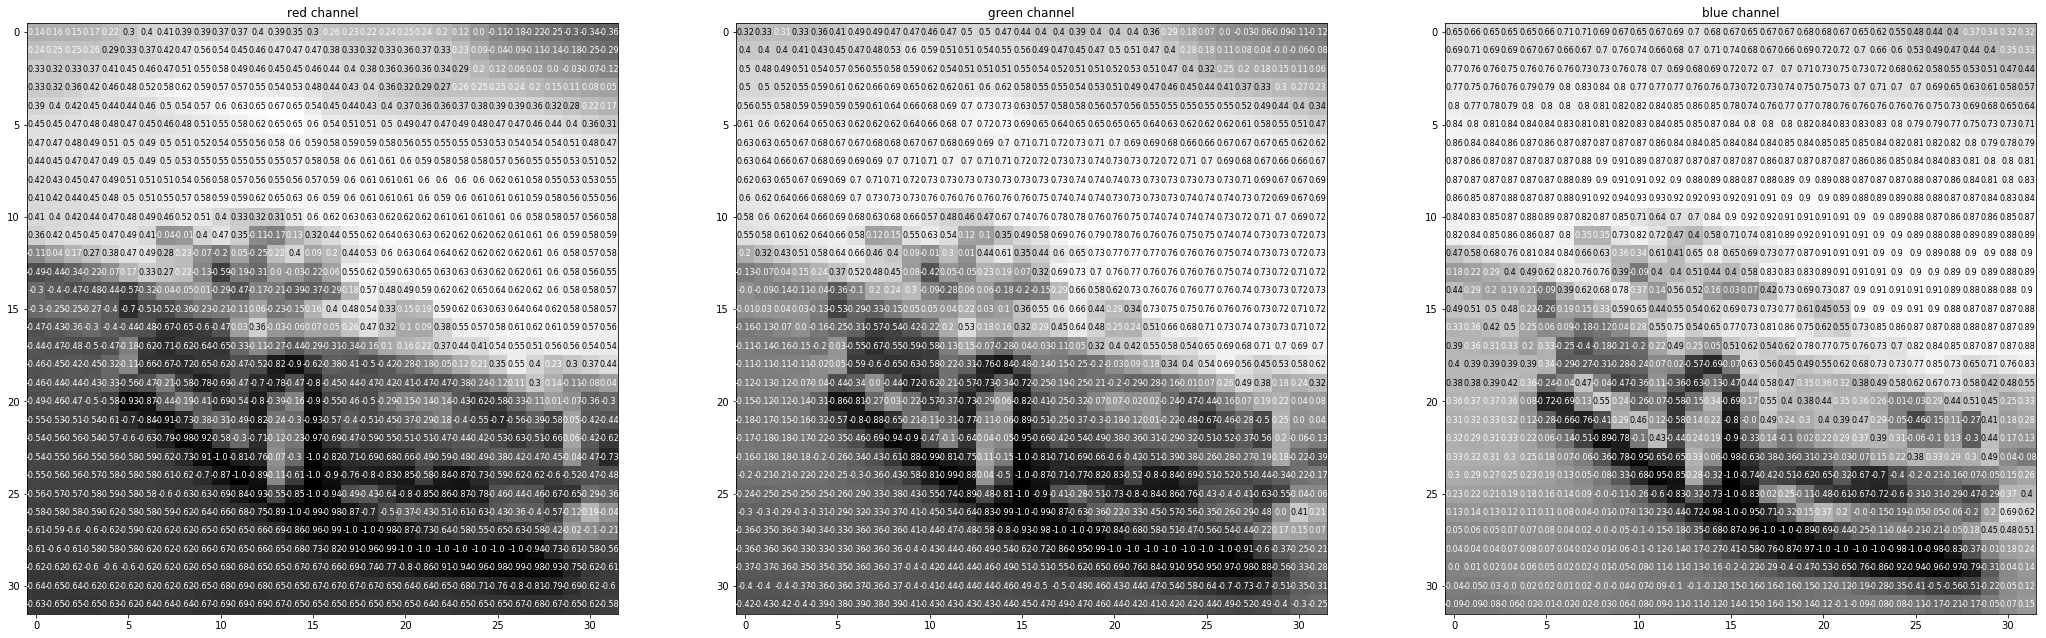

In [141]:
print("shape of images: {}".format(images[2].shape))
rgb_img = np.squeeze(images[2])
print("type: {} \t shape: {}".format(images[2].shape, rgb_img.shape))
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    print(width, height)
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center', size=8,
                        color='white' if img[x][y]<thresh else 'black')

### View each channel of images separately

In [142]:
import torch.nn as nn
import torch.nn.functional as F

In [172]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.35)
    
    def forward(self,x):
        #Remember what we are passing in: Tensor(#Imgs, Color, Height, Width)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Network()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [173]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = "cuda"
model.cuda()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [174]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #print(train_loss)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.843784 	Validation Loss: 1.843238
Validation loss decreased (inf --> 1.843238).  Saving model ...
Epoch: 2 	Training Loss: 1.843291 	Validation Loss: 1.843432
Epoch: 3 	Training Loss: 1.843186 	Validation Loss: 1.843472
Epoch: 4 	Training Loss: 1.843150 	Validation Loss: 1.843063
Validation loss decreased (1.843238 --> 1.843063).  Saving model ...
Epoch: 5 	Training Loss: 1.843380 	Validation Loss: 1.843113
Epoch: 6 	Training Loss: 1.843216 	Validation Loss: 1.842601
Validation loss decreased (1.843063 --> 1.842601).  Saving model ...
Epoch: 7 	Training Loss: 1.843340 	Validation Loss: 1.843378
Epoch: 8 	Training Loss: 1.843226 	Validation Loss: 1.844059
Epoch: 9 	Training Loss: 1.843233 	Validation Loss: 1.843627
Epoch: 10 	Training Loss: 1.843451 	Validation Loss: 1.842875
Epoch: 11 	Training Loss: 1.843363 	Validation Loss: 1.842568
Validation loss decreased (1.842601 --> 1.842568).  Saving model ...
Epoch: 12 	Training Loss: 1.843023 	Validation Loss: 1.8

In [163]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [168]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

IndexError: index 4 is out of bounds for dimension 0 with size 4